In [ ]:
!pip install keras
!pip install tensorflow

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

In [7]:
df = pd.read_csv("requirements.csv")
df.head()

requirement  label
0  When batteries are used on the equipment, they...      0
1  The Crew Oxygen hoses shall not be adversely a...      0
2  The slide/raft shall be capable of withstandin...      0
3  The Secondary Lock Actuator shall be designed ...      0
4  The main landing gear shall operate within the...      0

Environmental requirements are labeled 0. <br> 
Suitability requirements are labeled 1. 

In [8]:
requirements = df['requirement'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(requirements, y, stratify = y, test_size = 0.25, random_state = 42)

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X_train)  # Only fit the train data

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test) # There will be some unseen words here since the tokenizer only took into account the training set 

vocab_size = len(tokenizer.word_index)+1 # Adding 1 because of reserve 0 index

maxlen = 100 

# Padding sequences to make sure that each of them have same size --> post padding 
X_train = pad_sequences(X_train, padding = "post", maxlen = maxlen)
X_test = pad_sequences(X_test, padding = "post", maxlen = maxlen)

## GloVe Pre-trained word embeddings

Global vectors for word representation (GloVe) developed by Stanford NLP Group to obtain word embeddings. <br> 
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.


## Creating CNN for classification of requirements

In [11]:
from keras.models import Sequential
from keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=6,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/6
13/13 [==============================] - 1s 32ms/step - loss: 0.6261 - accuracy: 0.6822 - val_loss: 0.5690 - val_accuracy: 0.6744
Epoch 2/6
13/13 [==============================] - 0s 21ms/step - loss: 0.5091 - accuracy: 0.6822 - val_loss: 0.4730 - val_accuracy: 0.6744
Epoch 3/6
13/13 [==============================] - 0s 18ms/step - loss: 0.4084 - accuracy: 0.6822 - val_loss: 0.3898 - val_accuracy: 0.6744
Epoch 4/6
13/13 [==============================] - 0s 17ms/step - loss: 0.3300 - accuracy: 0.8140 - val_loss: 0.3385 - val_accuracy: 0.9302
Epoch 5/6
13/13 [==============================] - 0s 16ms/step - loss: 0.2647 - accuracy: 0.9302 - val_loss: 0.3027 - val_accuracy: 0.9302
Epoch 6/6
13/13 [==============================] - 0s 17ms/step - loss: 0.2303 - accuracy: 0.9767 - val_loss: 0.2832 - val_accuracy: 0.9302


## CNN model details

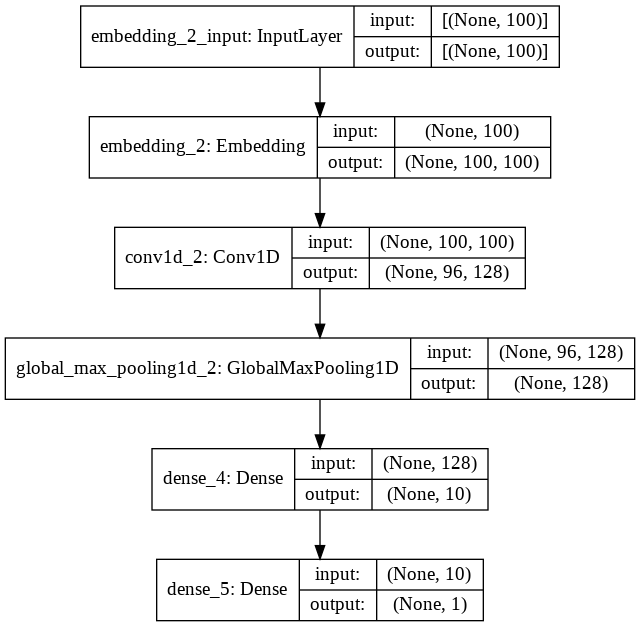

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Testing requirements provided by Boeing
The new requirements sent by Boeing (on Aug 16, 2021) are used as test examples as shown below. <br> 
The model not doing well for suitability requirements that have any environmental words in them. Example - `The bulk average precooler fan air exit temperature shall be limited to 3.1°F.`

In [38]:
requirement_test = [['The backup generators shall not be deteriorated by the environment to which they will be exposed.'], #Environmental
                    ['ASCS shall be designed to have a minimum service life of 3 years without major repair or replacement.'], # Suitabiity
                    ['The ELMS shall meet flammability requirements with engines not running to eliminate potential hazards for maintenance personnel.'], #Suitability
                    ['The bulk average precooler fan air exit temperature shall be limited to 3.1°F.'], #Suitability
                    ['The Converter shall not exceed the steady state heat rejection limits defined in Table BEPS12703.'], #Suitability
                    ['ASCS shall only require calibration at the time of manufacture and shop repair.'], #Suitability
                    ['The Generator shall be designed to support any load up to limit loads without deformation that results in performance degradation.'], #Environmental
                    ['The REUs shall be designed so that no damage will occur from reversal of power input polarity.'], #Environmental
                    ['The AG shall automatically recover normal operation in a timely manner after airplane exposure to lightning.'], #Environmental
                    ]

for x in requirement_test: 
  tokens = tokenizer.texts_to_sequences(x)
  maxlen = 100
  tokens_padded = pad_sequences(tokens, padding = "post", maxlen = maxlen)
  # requirement_test_token_padded
  k = model.predict([tokens_padded])
  if k > 0.5: 
    print(k, 'Suitability Requirement')
  elif k < 0.5: 
    print(k, 'Environmental Requirement')
  



[[0.02017736]] Environmental Requirement
[[0.52636087]] Suitability Requirement
[[0.52272606]] Suitability Requirement
[[0.18910733]] Environmental Requirement
[[0.2470656]] Environmental Requirement
[[0.52278185]] Suitability Requirement
[[0.10519716]] Environmental Requirement
[[0.21820521]] Environmental Requirement
[[0.00579315]] Environmental Requirement
